In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [16]:
from matplotlib import rcParams, pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GlobalMaxPooling1D, Conv1D, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
import warnings 
warnings.filterwarnings(action='ignore')

In [17]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print('No GPU detected')


1 Physical GPUs, 1 Logical GPU


In [18]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [19]:
data_dir = Path('/content/drive/MyDrive/dacon/input')
feature_dir = Path('../build/feature')
val_dir = Path('/content/drive/MyDrive/dacon/build/val')
tst_dir = Path('/content/drive/MyDrive/dacon/build/tst')
sub_dir = Path('/content/drive/MyDrive/dacon/build/sub')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test_x.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'author'
n_fold = 5
n_class = 5
seed = 42

In [20]:
algo_name = 'cnn'
feature_name = 'emb'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [48]:
train = pd.read_csv(trn_file, index_col=0)
train.head()

,text,author
index,,
0,"He was almost choking. There was so much, so m...",3
1,"“Your sister asked for it, I suppose?”",2
2,"She was engaged one day as she walked, in per...",1
3,"The captain was in the porch, keeping himself ...",4
4,"“Have mercy, gentlemen!” odin flung up his han...",3


In [49]:
test = pd.read_csv(tst_file, index_col=0)
test.head()

,text
index,
0,“Not at all. I think she is one of the most ch...
1,"""No,"" replied he, with sudden consciousness, ""..."
2,As the lady had stated her intention of scream...
3,“And then suddenly in the silence I heard a so...
4,His conviction remained unchanged. So far as I...


In [23]:
train[train['text'].str.contains("}")]

,text,author
index,,
5856,"This was on the second day of our flight, afte...",4
9983,But my uncle was not to be turned from his ide...,4
13245,"“I would be very sweir {11} to return,” says m...",4
16206,"At this I leaped from my place, went over to h...",4
17336,Even Professors might be misled by the desire...,2
18304,“Do you know how much?” I said. “Do you know h...,4
19917,"{4} But as for Grady, he began early to lamen...",4
22686,"Onyway it behoved him to get an auld, decent w...",4
23042,The cipaye led me forward accordingly to a pla...,4


In [50]:
train['text'] = train['text'].str.replace('\?',' quesmark ')
train['text'] = train['text'].str.replace('\!',' exclmark ')
train['text'] = train['text'].str.replace('\&',' empent ')
train['text'] = train['text'].str.replace("\*",' chstar ')
train['text'] = train['text'].str.replace(";",' smcolons  ')

test['text'] = test['text'].str.replace('\?',' quesmark ')
test['text'] = test['text'].str.replace('\!',' exclmark ')
test['text'] = test['text'].str.replace('\&',' empent ')
test['text'] = test['text'].str.replace("\*",' chstar ')
test['text'] = test['text'].str.replace(";",' smcolons  ')

In [51]:
train['text']=train['text'].str.replace('\'s', '')
train['text']=train['text'].str.replace('’s', '')
train['text']=train['text'].str.replace('\'ll', '')
train['text']=train['text'].str.replace('’ll', '')
train['text']=train['text'].str.replace("\'", '')
train['text']=train['text'].str.replace("’", '')

test['text']=test['text'].str.replace("’s",'')
test['text']=test['text'].str.replace("\'s",'')
test['text']=test['text'].str.replace('\'ll', '')
test['text']=test['text'].str.replace('’ll', '')
test['text']=test['text'].str.replace("\'", '')
test['text']=test['text'].str.replace("’", '')


In [52]:
train['text']=train['text'].str.replace('á', ' Ascenda ')
train['text']=train['text'].str.replace('à', ' Descenda ')
train['text']=train['text'].str.replace('â', ' Stremama ')
train['text']=train['text'].str.replace('ä', ' Doublea ')
train['text']=train['text'].str.replace('é', ' Ascende ')
train['text']=train['text'].str.replace('í', ' Justi ')
train['text']=train['text'].str.replace('ï', ' Doublei ')
train['text']=train['text'].str.replace('ó', ' Comao ')
train['text']=train['text'].str.replace('ú', ' Ascendu ')
train['text']=train['text'].str.replace('ý', ' Ascendy ')
train['text']=train['text'].str.replace('ü', ' Umlaut ')
train['text']=train['text'].str.replace('è', ' Descende ')
train['text']=train['text'].str.replace('£', ' Maludf ')

test['text']=test['text'].str.replace('ä', ' Doublea ')
test['text']=test['text'].str.replace('â', ' Stremama ')
test['text']=test['text'].str.replace('à', ' Descenda ')
test['text']=test['text'].str.replace('á', ' Ascenda ')
test['text']=test['text'].str.replace('é', ' Ascende ')
test['text']=test['text'].str.replace('ï', ' Doublei ')
test['text']=test['text'].str.replace('í', ' Justi ')
test['text']=test['text'].str.replace('ó', ' Comao  ')
test['text']=test['text'].str.replace('ú', ' Ascendu ')
test['text']=test['text'].str.replace('ý', ' Ascendy ')
test['text']=test['text'].str.replace('ü', ' Umalut ')
test['text']=test['text'].str.replace('è', ' Descende ')
test['text']=test['text'].str.replace('£', ' Maludf ')

In [53]:
train['text']=train['text'].str.replace('\(', ' \( ')
train['text']=train['text'].str.replace('\{', ' \{ ')
train['text']=train['text'].str.replace('\[', ' \[ ')
train['text']=train['text'].str.replace('\)', ' \) ')
train['text']=train['text'].str.replace('\}', ' \} ')
train['text']=train['text'].str.replace('\]', ' \] ')
train['text']=train['text'].str.replace('—', '')
train['text']=train['text'].str.replace('_', '')
train['text']=train['text'].str.replace(':', '')

test['text']=test['text'].str.replace('\(', ' \( ')
test['text']=test['text'].str.replace('\{', ' \{ ')
test['text']=test['text'].str.replace('\[', ' \[ ')
test['text']=test['text'].str.replace('\)', ' \) ')
test['text']=test['text'].str.replace('\}', ' \} ')
test['text']=test['text'].str.replace('\]', ' \] ')
test['text']=test['text'].str.replace('—', '')
test['text']=test['text'].str.replace('_', '')
test['text']=test['text'].str.replace(':', '')

In [54]:
train[train['text'].str.contains(']')]

,text,author
index,,
375,The Light upon the Moor \[ Second Report of D...,2
2599,"“Mr. odin exclmark ” cried odin, seeming glad ...",3
3763,“At first he only talked about it in tavernshe...,3
4010,"“Do you consider, Doctor, that there is immedi...",1
4341,\[ chstar \] Dostoevsky appears to have f...,3
6721,“That was how Enoch odin came to his end. All ...,1
7257,odin and odin exchanged glances as if they tho...,1
7307,"Half an hour after this conversation, she went...",3
7436,\[ chstar \] The emancipation of the serf...,3


In [55]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [56]:
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import TweetTokenizer

def lemma_text(text):
    tokenizer=TweetTokenizer()
    words=tokenizer.tokenize(text)
    lem = WordNetLemmatizer()
    words=[lem.lemmatize(word, "v") for word in words]
    
    clean_sent=" ".join(words)
    
    return clean_sent

train['text'] = train['text'].str.lower().apply(lemma_text)
test['text'] = test['text'].str.lower().apply(lemma_text)

In [32]:
train[train['text'].str.contains("'ll")]


,text,author
index,,


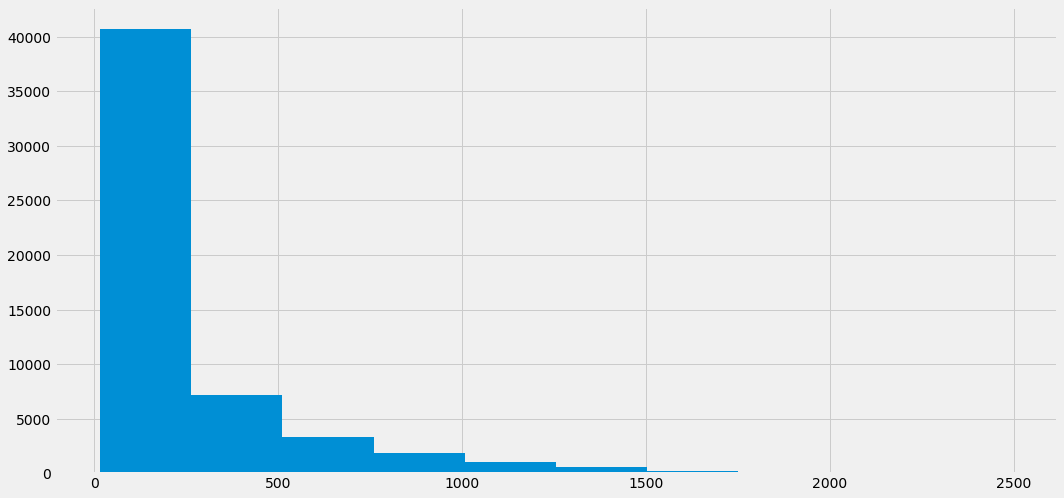

In [33]:
train['text'].str.len().hist()

In [57]:
X_trn = train['text'].values
X_tst = test['text'].values
y = train['author'].values
print(X_trn.shape, X_tst.shape, y.shape)

(54879,) (19617,) (54879,)


In [58]:
vocab_size = 21000
embedding_dim = 128
max_length = 550
padding_type='post'

In [59]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_trn)
word_index = tokenizer.word_index

In [60]:

train_sequences = tokenizer.texts_to_sequences(X_trn)
test_sequences = tokenizer.texts_to_sequences(X_tst)

In [61]:
trn = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)
tst = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)
print(trn.shape, tst.shape)

(54879, 550) (19617, 550)


In [62]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [63]:
def get_model():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Dropout(0.2),
        Conv1D(256, 3, padding='valid', activation='relu', strides=1),  
        GlobalMaxPooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(n_class, activation='softmax')
    ])
    
    # compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=.005))
    return model

In [64]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)

    clf = get_model()    
    clf.fit(trn[i_trn], 
            to_categorical(y[i_trn]),
            validation_data=(trn[i_val], to_categorical(y[i_val])),
            epochs=10,
            batch_size=256,
            callbacks=[es])
    p_val[i_val, :] = clf.predict(trn[i_val])
    p_tst += clf.predict(tst) / n_fold

training model for CV #1
Epoch 1/10
172/172 [==============================] - 16s 94ms/step - loss: 0.9564 - val_loss: 0.6665
Epoch 2/10
172/172 [==============================] - 16s 92ms/step - loss: 0.5395 - val_loss: 0.6003
Epoch 3/10
172/172 [==============================] - 16s 95ms/step - loss: 0.3801 - val_loss: 0.6491
Epoch 4/10
172/172 [==============================] - 16s 94ms/step - loss: 0.2922 - val_loss: 0.7210
Epoch 5/10
172/172 [==============================] - 16s 94ms/step - loss: 0.2417 - val_loss: 0.7973
Epoch 00005: early stopping
training model for CV #2
Epoch 1/10
172/172 [==============================] - 16s 94ms/step - loss: 0.9720 - val_loss: 0.6923
Epoch 2/10
172/172 [==============================] - 16s 95ms/step - loss: 0.5544 - val_loss: 0.5986
Epoch 3/10
172/172 [==============================] - 16s 95ms/step - loss: 0.3966 - val_loss: 0.6558
Epoch 4/10
172/172 [==============================] - 16s 95ms/step - loss: 0.2988 - val_loss: 0.6790
Epoc

In [65]:
print(f'Accuracy (CV): {accuracy_score(y, np.argmax(p_val, axis=1)) * 100:8.4f}%')
print(f'Log Loss (CV): {log_loss(pd.get_dummies(y), p_val):8.4f}')


Accuracy (CV):  78.1702%
Log Loss (CV):   0.5987


In [66]:

np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

In [67]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(19617, 5)


,0,1,2,3,4
index,,,,,
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [68]:
sub[sub.columns] = p_tst
sub.head()

,0,1,2,3,4
index,,,,,
0,0.0292,0.6978,0.2351,0.0366,0.0014
1,0.4128,0.1591,0.0535,0.1109,0.2637
2,0.9920,0.0050,0.0009,0.0008,0.0014
3,0.0553,0.0086,0.8805,0.0115,0.0441
4,0.5561,0.0144,0.0947,0.1836,0.1512


In [69]:
sub.to_csv(sub_file)